# 2019 2nd ML month with KaKR
- 참고자료 : https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr/overview

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 데이터 불러오기

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 날짜 변환
- date컬럼에 필요없는 부분이 많이 있음(시간 부분)
- 이걸 떼버리고 사용하려고 함

In [4]:
train["date"] = train.date.str[:8].astype(int)
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


### 타겟변수 따로 저장하기

In [5]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
y = train["price"]
del train["price"]

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
del train["id"]

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 테스트 데이터에 대해서도 똑같이 적용

In [8]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [9]:
# 날짜 변환
test["date"] = test["date"].str[:8].astype(int)
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [10]:
# test데이터 id삭제하기
test_id_sub = test["id"]  # 삭제하기 전에 id를 따로 저장해놓자
del test["id"]

In [11]:
test

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141209,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,20141209,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,20140512,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,20150415,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,20150312,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,20140626,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,20150126,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,20150219,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,20140623,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [12]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

## 데이터 확인

__각 피처들의 분포 확인__

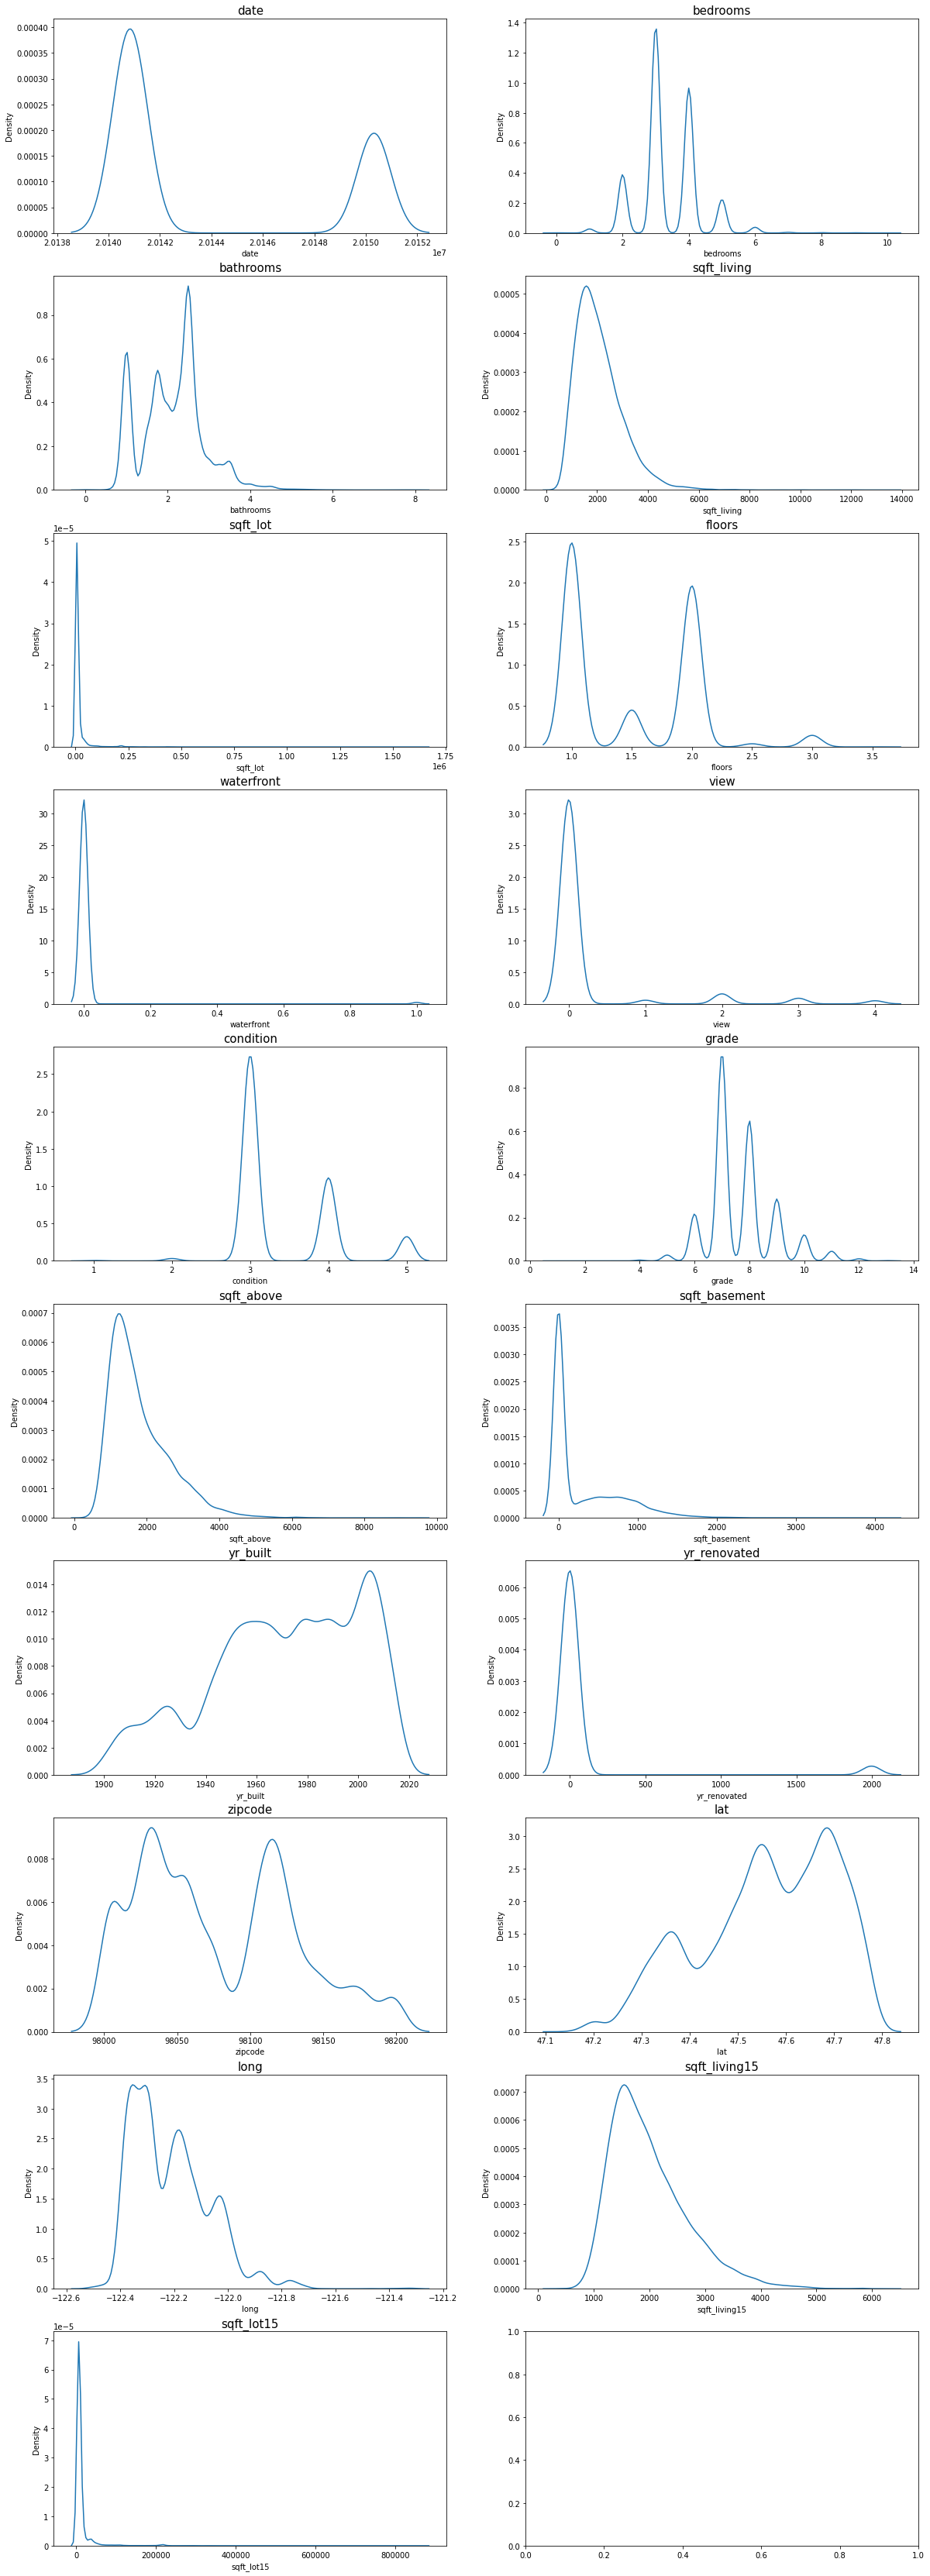

In [13]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

__피처 스케일링__

In [25]:
# 훈련세트 변경
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

In [26]:
# 테스트 세트 변경
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

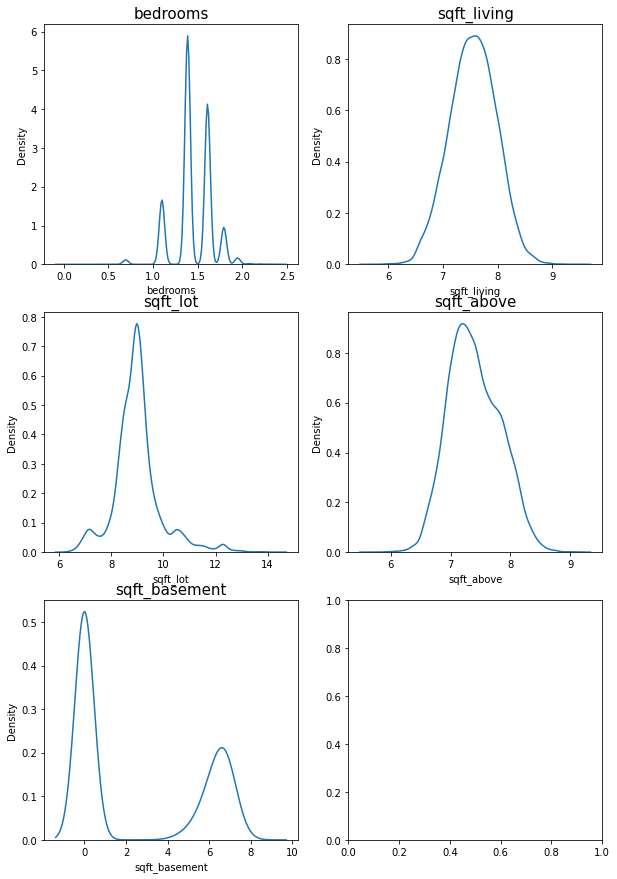

In [27]:
# 정규화된 그래프
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

__target 값 분포 확인__

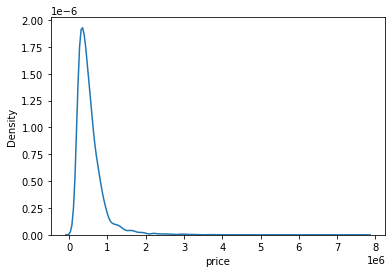

In [14]:
# kde 그래프로 분포 확인
sns.kdeplot(y)
plt.show()

__로그 변환__
- 한 쪽으로 치우친 데이터를 표준화하기 위해서 로그함수를 씌워서 변환
- 잊지말고 마지막에 지수함수를 씌워줘야함

In [15]:
y_log = np.log1p(y)
y_log

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

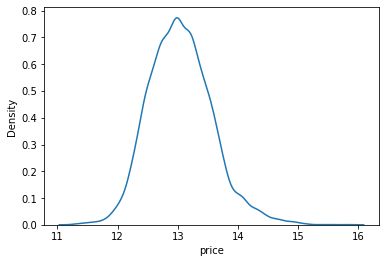

In [16]:
sns.kdeplot(y_log)
plt.show()

## 모델 평가
- 머신러닝 모델을 학습시키고 튜닝하기 위해서는 다양항 모델로 실험을 해봐야함
- RMSE 점수로 모델들을 평가하고 특별히 모자란 모델은 제외하고 학습시키도록 한다.

__RMSE 계산__

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

- 대회 평가 방식이 RMSE를 기준으로 하는 만큼 RMSE를 빠르게 구해줄 도구가 필요함
- 다만 우리가 예측하는 y값은 log가 씌워져 있으므로 exp를 자동으로 해서 구해주는 함수가 있으면 편할수 있음

In [30]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

__모델 불러오기__
- 다음으로 XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델을 사용

In [31]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [32]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {"model":rdforest, "name" : "RandomForest"}]

In [33]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model["name"]

        # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train,
                                                            y,
                                                            random_state = random_state,
                                                            test_size = 0.2)

        # 모델 학습
        model["model"].fit(X_train, y_train)

        # 예측
        y_pred = model["model"].predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index = ["RMSE"]).T.sort_values("RMSE", ascending = False)
    return score_df

In [34]:
get_scores(models, train, y_log)

,RMSE
GradientBoosting,127023.353828
RandomForest,125527.686262
LightGBM,111008.952321
XGBoost,110987.069549


## 그리드 탐색

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
import warnings
"""
다음과 같은 과정을 진행할 수 있는 
`my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 
함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose = 2, n_jobs = 5):
    # 1. GridSearchCV 모델로 'model'을 초기화합니다. 
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring = 'neg_mean_squared_error', \
                        cv = 5, verbose = verbose, n_jobs = n_jobs)
    
    # 모델을 fitting 합니다.
    grid_model.fit(train, y)
    
    # params, score에 각 조합에 대한 결과를 저장합니다. 
    params = grid_model.cv_results_["params"]
    score = grid_model.cv_results_["mean_test_score"]
    
    # 데이터 프레임을 생성하고,  
    params_score = pd.DataFrame(params)
    params_score["score"] = score
    
    # RMSLE 값을 추가한 후 점수가 높은 순서로 정렬하고 값을 반환한다.
    params_score["RMSLE"] = np.sqrt(-score)
    params_score.sort_values(by="RMSLE", ascending = False, inplace = True)
    
    return params_score


In [58]:
# LGBMRegressor 파라미터 평가
warnings.filterwarnings('ignore')
param_grid = {
    'n_estimators': [1000, 10000],
    'max_depth': [1, 10],
    "learning_rate" : [0.05, 0.1]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y_log, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [ ]:
# XGBoost 파라미터 평가
warnings.filterwarnings('ignore')
param_grid = {
    'n_estimators': [10, 10000],
    'max_depth': [1, 10],
    "learning_rate" : [0.05, 0.1]
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y_log, param_grid, verbose=2, n_jobs=5)

In [43]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state = random_state)
lightgbm = LGBMRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 1000, random_state = random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

models = [ {'model':xgboost, 'name':'XGBoost'},{'model':lightgbm, 'name':'LightGBM'}]

In [44]:
get_scores(models, train, y_log)

,RMSE
XGBoost,110385.368413
LightGBM,108815.926532


__Cross Validation__

In [41]:
def get_cv_score(models, x, y):
    kfold = KFold(n_splits=5, random_state=random_state, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), kf=kfold))

In [45]:
get_cv_score(models, train, y_log)

Model XGBoost CV score : 0.9052
Model LightGBM CV score : 0.9057


### 제출파일 만들기
- 모델 학습부터 예측, 제출파일까지 만들어주는 함수 생성

In [54]:
models

[{'model': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.05, max_delta_step=0, max_depth=10,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=2, num_parallel_tree=1,
               random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               subsample=1, tree_method='exact', validate_parameters=1,
               verbosity=None),
  'name': 'XGBoost'},
 {'model': LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=1000,
                random_state=2020),
  'name': 'LightGBM'}]

In [55]:
models[0]["model"].fit

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=2, num_parallel_tree=1,
             random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [49]:
def save_submission(models, train, y, test):
    for model in models:
        # 모델을 train, y로 학습
        model["model"].fit(train, y)

    # 모든 모델 test에 대해 예측
    predictions = np.column_stack([model["model"].predict(test.values) for model in models])
    
    # 예측값을 np.exp,1로 변환
    predictions = np.expm1(predictions)
    
    # 모델들의 예측값 평균
    predictions = np.mean(predictions, axis=1)
    
    # 데이터프레임으로 변환
    df = pd.DataFrame(test_id_sub)
    df["price"] = predictions
    df.reset_index(drop =True)
    
    # submossion_model_name_RMSLE_100000.csv 로 저장
#     data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
#     submission_csv_path = f'{data_dir}/submossion_{model_name}_RMSLE_{rmsle}.csv'
    df.to_csv("tj_submission.csv", index = False)
    
    print("Success Save!")

In [56]:
save_submission(models, train, y_log, test)

Success Save!


# 캐글 제출 결과
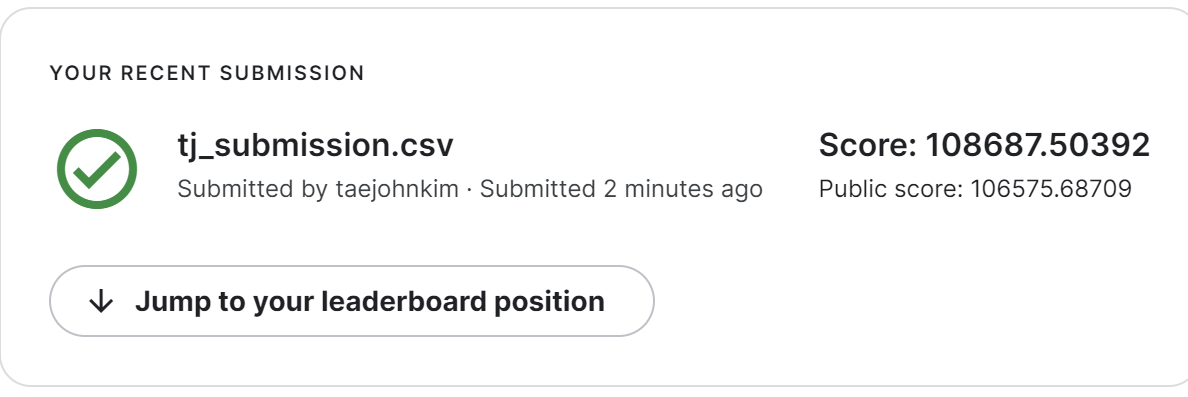

# 회고

1. 어려웠던점
    - 너무 많은 머신러닝 모델들이 나왔고 이들의 파라미터들을 공부하게 되어서 이해하기가 벅찼다. 
    - 지금까지 했던 익스중에 가장 어려웠다 
    - 특히 모델을 평가하고 학습하는데 너무 오랜 시간이 걸려서 과제를 마치는데 힘들었다. 

2. 배운점
    - 힘들었던 만큼 성능을 향상시키기 위해서 파라미터와 모델에 대해서 많이 공부할 수 있는 시간이 되었다. 


3. 느낀점
    - 본격적으로 데이터를 다룬다는 느낌을 받을 수 있는 노드였다. 
    - 정말 어려웠지만 